### Example Notebook to bench test all the pieces and make improvements for tuning repeatability. Also should serve as a first order walkthrough of the process for demonstrations (Results may vary)

##### Probabalistic Demonstration of A Bayesian Changepoint analysis, Inncluding a rudimentary correlation and forecasting solutions

#### Goals:
##### Take a number of input well logs, from a geoligically similar basin and analyse them by identifying changepoints and data trends that will be used to interprete property changes and characterize the subsurface. Follow by simulating a drilling campaign

#### Outline: 
##### Volve Dataset will be used as a test case of the analysis, 5 wells have been drilled in the north sea Volve field offshore of southern Norway. This notebook will try to forcast the probability of property changes from a hypothetical drilling campaign, while drilling. Simulated by incremetally adding data to the analysis from a known well.

###### Some background info... and nomenclature. I've decided to use the vernacular 'CompariTEE' and 'CompariTOR' to describe the Unknown and known wells, if only to capitalize on the neumonic *Prior/Tor* it really could have gone either way.

###### Comparitor ('priors') wells: 15-9: F1, F1A, F1B, F1C, F11B, F11T2 
###### Comparitee (investigation) wells: 15-9-F11A 


###### adam jones 05.07.23

In [1]:
'''Loading dependencies''' 

import matplotlib.pyplot as plt
import numpy as np
#import ruptures as rpt
import welly
import pandas as pd
import scipy.stats as stats

#Collections of self built methods
import cp_comparitor as cp_Comp
import change_point_tools as cp_Tools
import well_tools as wtool

# This is testing module
import test_func as tst

In [2]:
# OS well path 
#path = 'C:\\Users\\ada55080\\git\different_bayes\\volve_well_data\\'
path = '.\\volve_well_data\\'

##### Loading Wells into memory, Volve wells 15-9: F1, F1A, F1B, F1C, F11B, F11



In [3]:
# These are pretty well groomed but lack some spatial data (TVD, Lat/Long, etc...)

f1 = welly.Well.from_las(path + '15_9-F-1\\15_9_F1_complete.las')
f1A = welly.Well.from_las(path + '15_9-F-1A\\15_9-F-1A.las')
f1B = welly.Well.from_las(path + '15_9-F-1B\\15_9-F-1B.las')
f1C = welly.Well.from_las(path + '15_9-F-1C\\15_9-F-1C.las')
f11A = welly.Well.from_las(path + '15_9-F-11A\\15_9-F-11A.las')
f11B = welly.Well.from_las(path + '15_9-F-11B\\15_9-F11B.las')

##### The following dictionaries are place holder variables.

In [4]:

#Rolling average parameters

# window = 30
# periods = 3

# setting global variables for the ruptures PELT parameters pen and min_size 
# RHOB_glob_pen = 0.5
# RHOB_glob_min = 10

# NPHI_glob_pen = 0.1
# NPHI_glob_min = 10

# GR_glob_pen = 1300
# GR_glob_min = 10


# string label varables'
# dataGR = "GR"
# dataRHOB = "RHOB"
# dataNPHI = "NPHI"

#Well names lists for automation
_wellnames = ['df_f1','df_f1A', 'df_f1B', 'df_f1C', 'df_f11A', 'df_f11B']
_wells = [f1, f1A, f1B, f1C, f11A, f11B]
_log_list = ['NPHI','RHOB','GR','DT','PEF']
_log_list_GR = ['GR']
_log_list_nodt = ['NPHI','RHOB','GR','PEF']


# Dictionaries for well extents in meters below surface, these extents are mostly consistent and exist for all input logs

_logname_extent_min = {'f1': 2620 ,'f1A' : 2620, 'f1B' : 3100 , 'f1C': 3100 , 'f11A' : 2600 , 'f11B': 3200 }
_logname_extent_max = {'f1': 3590 ,'f1A' : 3600, 'f1B' : 3400 , 'f1C': 4100 , 'f11A' : 3700 , 'f11B': 4550 }
_log_extent_min = {0 : 2620, 1 : 3100 , 2: 3100 , 3 : 2600 , 4: 3200 }
_log_extent_max = {0: 3600, 1 : 3400 , 2: 4100 , 3 : 3700 , 4: 4550 }


##### Loading Volve Well logs... These logs do not have any spacial awareness so everthing is relative to the Measured Depth
######  in the borehole future implementations will need some 3D awareness to be convincing, as these particular wells are controlled for depth and are clearly in the same basin they can work for this illustration

In [5]:
# Writing well log values to dataframe, index is MD(measured depth)
df_f1 = _wells[0].df(_log_list)
df_f1A = _wells[1].df(_log_list)
df_f1B = _wells[2].df(_log_list)
df_f1C = _wells[3].df(_log_list)
df_f11A = _wells[4].df(_log_list)
df_f11B = _wells[5].df(_log_list)

df_f1clip = df_f1[_logname_extent_min['f1']:_logname_extent_max['f1']]
'''Un-Comment for Building dataframes with Rolling Averages'''
data_f1A = wtool.compute_all_rolling_avg(df_f1A, window=30, periods=3)
data_f1B = wtool.compute_all_rolling_avg(df_f1B, window=30, periods=3)
# data_f1C = wtool.compute_all_rolling_avg(df_f1C, window=30, periods=3)
data_f11A = wtool.compute_all_rolling_avg(df_f11A, window=30, periods=3)
# data_f11B = wtool.compute_all_rolling_avg(df_f11B, window=30, periods=3)


c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\cu

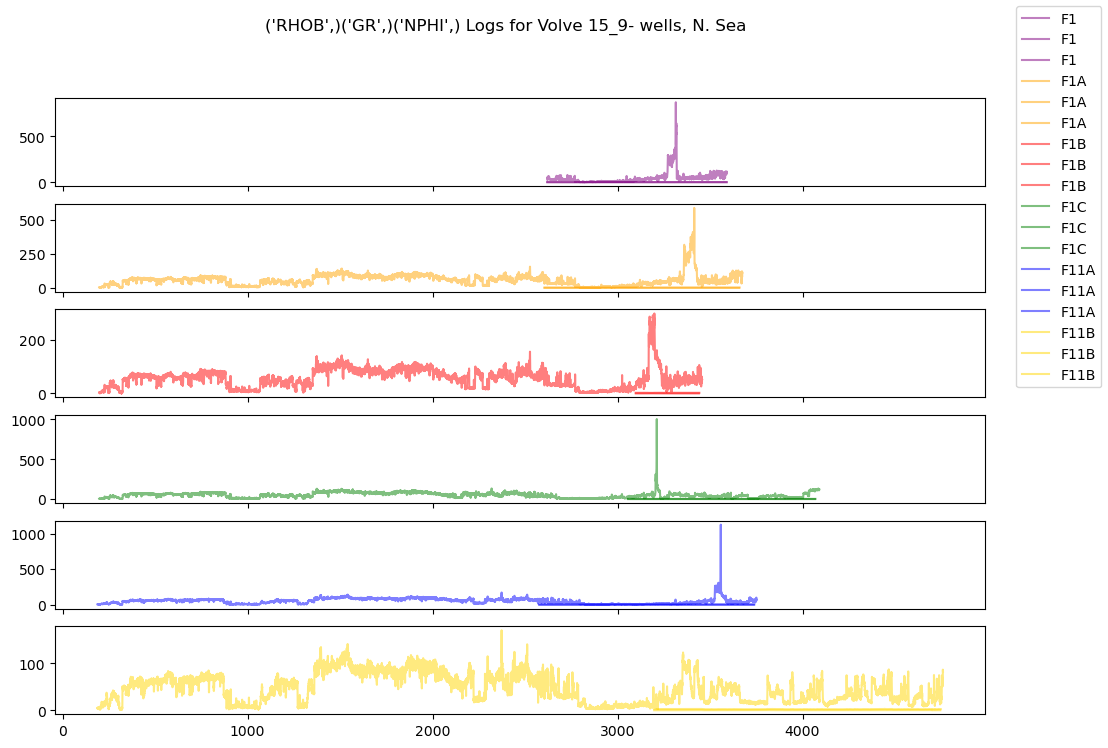

In [6]:
'''Ploting to check everything is importing correctly'''
log = ['RHOB', 'GR', 'NPHI']

lognames = ''
for i in zip(log): lognames += str(i)
fig, ax = plt.subplots(6, figsize=(12,8), sharex=True)
fig.suptitle(lognames+' Logs for Volve 15_9- wells, N. Sea')
ax[0].plot(df_f1clip[log], label='F1', color= 'purple', alpha=0.5)
ax[1].plot(df_f1A[log], label='F1A', color='orange', alpha=0.5)
ax[2].plot(df_f1B[log], label='F1B', color='red', alpha=0.5)
ax[3].plot(df_f1C[log], label='F1C', color='green', alpha=0.5)
ax[4].plot(df_f11A[log], label='F11A', color='blue', alpha=0.5)
ax[5].plot(df_f11B[log], label='F11B', color='gold', alpha=0.5)
fig.legend()

##### Testing cell that searches for changepoint probabilitiesfor the input well logs

In [7]:
# ''' This is a helper function will groom the ends (by holding values) and remove NaN's of an
#     incomplete dataset and perform a Bayesian changepoint search.

#     results of the search will be added to another row of the dataframe.

#     Really should be building a well 'object' that holds this data along with the
#     trends and correlation to other wells, but for now it is a dataframe...

# '''

# def df_add_CP_Prob(df, log_dict=[], label='CP_Prob_', nan_method='local_average', window_size=200, segment_length=1000, **kwargs):
    
#      #Keyword Args assingment
#     _prior = kwargs.get('prior') # choices are "const", "geometric", "neg_binomial"
#     _method = kwargs.get('method')  # choices are 'gauss', 'ifm' or 'full_cov'
#     _engine = kwargs.get('engine')  # choices are "numpy" or "numba"

#     #Argument Defaults
#     if _method == None:
#         _method = "full_cov"
#     if _prior == None:
#         _prior = "const"
#     if _engine == None:
#         _engine ="numba"
    
#     #Fill ends of incomplete df, replace NaN's with parameter method, and changepoint search with parameter segment splits
#     for log in log_dict:
#         print(log+' finding changepoints')
#         labl = label+log
#         df[log] = wtool.fill_out_data_ends(df[log].values)

#         df[log] = wtool.replace_nans(df[log].values, method=nan_method, window_size=window_size)
        
#         df[labl] = cp_Tools.bayes_offline_split(df[log].values, segment_length=segment_length, method=_method, prior=_prior, engine=_engine)

        

In [8]:
''' ! ! ! AUCHTUNG ! ! !  ***** This cell will take a bit of time to compute, *****  

time for coffee break? or just take your eyes off the screen.

it took about 15 min with sequence_length=700 I have them individually commented for convenience
to reduce the compute time, reduce the _segment_length variable as this will lighten the computational load
'''

_segment_length = 500 # the method will split the dataset into equal chunks to compute their probabilities separately, mostly for computational efficiency
_window_size = 100 # when filling missing data with the 'local_average' method, this is the parameter fed into np.convolve to impute the missing vals

cp_Comp.df_add_CP_Prob(df_f1clip, log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

cp_Comp.df_add_CP_Prob(df_f1A, log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

cp_Comp.df_add_CP_Prob(df_f1B, log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

cp_Comp.df_add_CP_Prob(df_f1C, log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

cp_Comp.df_add_CP_Prob(df_f11A, log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

cp_Comp.df_add_CP_Prob(df_f11B, log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

# #df_CP_Prob(df_f1A, log_dict=['GR'], label='CP_Prob_', method='local_average', window_size=_window_size, segment_length=_segment_length)

#### template ##### df_CP_Prob(df, log_dict=[], label='CP_Prob_', method='local_average', window_size=_window_size, segement_length=_segment_length)






NPHI finding changepoints
method- full_cov, prior- const, engine- numba
Segmenting into 500


c:\Users\ada55080\git\different_bayes\cp_comparitor.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log] = wtool.fill_out_data_ends(df[log].values)
c:\Users\ada55080\git\different_bayes\cp_comparitor.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log] = wtool.replace_nans(df[log].values, method=nan_method, window_size=window_size)


/nRHOB finding changepoints500: 9700 of 9700
method- full_cov, prior- const, engine- numba
Segmenting into 500


c:\Users\ada55080\git\different_bayes\cp_comparitor.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[labl] = cp_Tools.bayes_offline_split(df[log].values, segment_length=segment_length, method=_method, prior=_prior, engine=_engine)
c:\Users\ada55080\git\different_bayes\cp_comparitor.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log] = wtool.fill_out_data_ends(df[log].values)
c:\Users\ada55080\git\different_bayes\cp_comparitor.py:209: SettingWithCopyWarning: 
A value is trying to be set on 

/nGR finding changepoints 9500: 9700 of 9700
method- full_cov, prior- const, engine- numba
Segmenting into 500


c:\Users\ada55080\git\different_bayes\cp_comparitor.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[labl] = cp_Tools.bayes_offline_split(df[log].values, segment_length=segment_length, method=_method, prior=_prior, engine=_engine)
c:\Users\ada55080\git\different_bayes\cp_comparitor.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log] = wtool.fill_out_data_ends(df[log].values)
c:\Users\ada55080\git\different_bayes\cp_comparitor.py:209: SettingWithCopyWarning: 
A value is trying to be set on 

/nPEF finding changepoints9500: 9700 of 9700
method- full_cov, prior- const, engine- numba
Segmenting into 500


c:\Users\ada55080\git\different_bayes\cp_comparitor.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[labl] = cp_Tools.bayes_offline_split(df[log].values, segment_length=segment_length, method=_method, prior=_prior, engine=_engine)
c:\Users\ada55080\git\different_bayes\cp_comparitor.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log] = wtool.fill_out_data_ends(df[log].values)
c:\Users\ada55080\git\different_bayes\cp_comparitor.py:209: SettingWithCopyWarning: 
A value is trying to be set on 

/nNPHI finding changepoints500: 9700 of 9700
method- full_cov, prior- const, engine- numba
Segmenting into 500


c:\Users\ada55080\git\different_bayes\cp_comparitor.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[labl] = cp_Tools.bayes_offline_split(df[log].values, segment_length=segment_length, method=_method, prior=_prior, engine=_engine)


/nRHOB finding changepoints5000: 35361 of 35361
method- full_cov, prior- const, engine- numba
Segmenting into 500
/nGR finding changepoints 35000: 35361 of 35361
method- full_cov, prior- const, engine- numba
Segmenting into 500
/nPEF finding changepoints35000: 35361 of 35361
method- full_cov, prior- const, engine- numba
Segmenting into 500
/nNPHI finding changepoints5000: 35361 of 35361
method- full_cov, prior- const, engine- numba
Segmenting into 500
/nRHOB finding changepoints3000: 33191 of 33191
method- full_cov, prior- const, engine- numba
Segmenting into 500
/nGR finding changepoints 33000: 33191 of 33191
method- full_cov, prior- const, engine- numba
Segmenting into 500
/nPEF finding changepoints33000: 33191 of 33191
method- full_cov, prior- const, engine- numba
Segmenting into 500
/nNPHI finding changepoints3000: 33191 of 33191
method- full_cov, prior- const, engine- numba
Segmenting into 500
/nRHOB finding changepoints9000: 39481 of 39481
method- full_cov, prior- const, engine- 

##### Segment lengths for the changepoint detection have sunstantial influence on the posterior probability curve

###### Where this effect is less pronounced in datasets with more variance, there are some sequences with obvious shifts that are not recognized by the algorithm unless the prior data sufficiently encapsulates the data variance from within multiple changes within the data. This limitation demands that to some extent, tuning is required to best characterize the probabilties found with this method so as to avoid false positives or build additional confidence factors

###### In a practical sense, this tuning could be derived stochastically or by way of weighting change points found in this method with other discrete change point methods, such as PELT, or by evaluating the likeliness with a focused single change point method.  But, these will further add to the computational cost for analysis.



In [45]:
''' This cell will take quite some time to compute, 60+ minutes in previous attempts

It will compute the probability of a normalized curve for change points in the dataset, and this is used to display the
relative importance for tuning the Bayesian changepoint algorithm for not only completeness of the solution i.e. find all 
the useful changepoints, but also to not "overspend" on the computing time to achieve this.

As a practical limitation for the framework, a great deal of this computation time can be handled in a step before the
active analysis of input data, but this step will grow proportionally with the increase in input data.'''

#df_f1clip[['CP_Prob_RHOB','CP_Prob_PEF']].plot(alpha=0.7)
#plt.plot(cp_Tools.normalize_array(df_f1clip['PEF'],0,0))
#PEF_seg_1000 = cp_Tools.bayes_offline_split(cp_Tools.normalize_array(df_f1clip['PEF'].values,0,0), segment_length=1000, method='full_cov', prior='const', engine='numba', normal=True)

#PEF_seg_3000 = cp_Tools.bayes_offline_split(cp_Tools.normalize_array(df_f1clip['PEF'].values,0,0), segment_length=3000, method='full_cov', prior='const', engine='numba', normal=True)

#PEF_seg_6000 = cp_Tools.bayes_offline_split(cp_Tools.normalize_array(df_f1clip['PEF'].values,0,0), segment_length=6000, method='full_cov', prior='const', engine='numba', normal=True)

# PEF_ = cp_Tools.bayes_offline_sdt(cp_Tools.normalize_array(df_f1clip['PEF'].values,0,0), method='full_cov', prior='const', engine='numba', normal=True)

method- full_cov, prior- const, engine- numba
Segmenting into 1000
/nmethod- full_cov, prior- const, engine- numba
Segmenting into 3000
/nmethod- full_cov, prior- const, engine- numba
Segmenting into 6000
/nmpleted segment 2 from 6000: 9700 of 9700

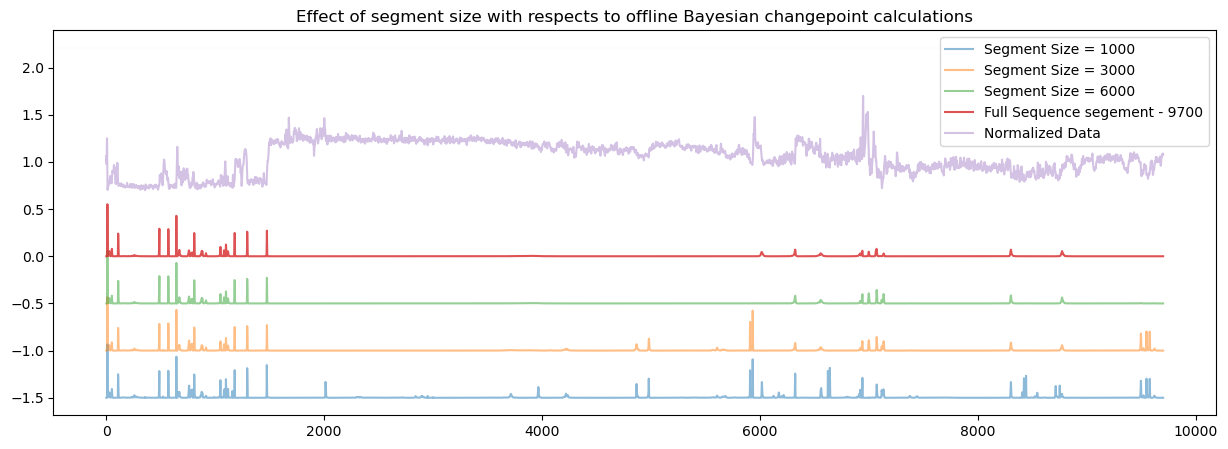

In [60]:
# Plotting the resuts from the cell above

plt.figure(figsize=(15,5))

plt.plot(PEF_seg_1000-1.5, alpha=0.5, label='Segment Size = 1000')
plt.plot(PEF_seg_3000-1, alpha=0.5, label='Segment Size = 3000')
plt.plot(PEF_seg_6000-.5, alpha=0.5, label='Segment Size = 6000')
#plt.plot(cp_Tools.normalize_array(df_f1clip['PEF'],0,0))
plt.plot(PEF_, alpha=0.8, label='Full Sequence segement - 9700')
plt.plot(cp_Tools.normalize_array(df_f1clip['PEF'].values,0,0)+.7, alpha=0.4, label='Normalized Data')
plt.legend(loc='upper right')
plt.axhline(2.21, alpha=.01)
plt.title('Effect of segment size with respects to offline Bayesian changepoint calculations');

##### There is also a question of noise reduction, for example by computing the rolling average of a dataset.
###### a rolling average is often used to deconvolute the data so that changepoints are less obscured ba them, but it seems that the Offline Bayesian search function is quite robustly finding changepoints without this step. 
###### Arguably, it even does a better job with RAW data, this simple comparison is meant to demonstrate that.

GR finding changepoints
method- full_cov, prior- const, engine- numba
Segmenting into 300
/nRoll_Avg_GR finding changepoints35361 of 35361
method- full_cov, prior- const, engine- numba
Segmenting into 300
/nmpleted segment 118 from 35100: 35361 of 35361

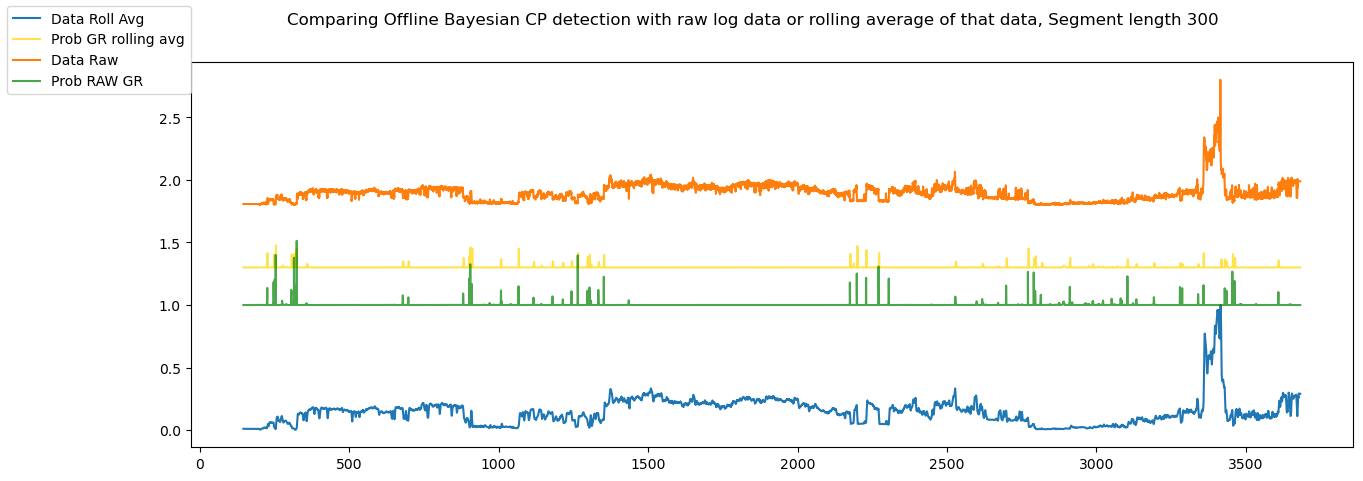

In [9]:
''' This Shows that performing the change point analysis on a log and a rolling average of the log produce comparable results, if not slightly muted for the Avg.'''
#data_f1A = wtool.compute_all_rolling_avg(df_f1A, window=30, periods=3)

cp_Comp.df_add_CP_Prob(data_f1A, log_dict=['GR', 'Roll_Avg_GR' ], label='CP_Prob_', nan_method='local_average', window_size=200, segment_length=300)

fig, ax = plt.subplots(1, figsize=(15,5))

#ax[0].plot(data_f1A['CP_Prob_Roll_Avg_GR']-data_f1A['CP_Prob_GR'])
ax.plot(data_f1A['Roll_Avg_GR']/data_f1A['Roll_Avg_GR'].max(), label='Data Roll Avg')
ax.plot(data_f1A['CP_Prob_Roll_Avg_GR']+1.3, label='Prob GR rolling avg', alpha=0.7, color='gold')

ax.plot(data_f1A['GR']/data_f1A['GR'].max()+1.8, label='Data Raw')
ax.plot(data_f1A['CP_Prob_GR']+1, label='Prob RAW GR', color='green', alpha=0.7)

fig.suptitle('Comparing Offline Bayesian CP detection with raw log data or rolling average of that data, Segment length 300')
fig.legend(loc=('upper left'));


##### Establishing changepoint statistics for all input wells. these will be used for geometric comparison with the stats. of change points of a compariTEE(unknown or investigated well) to compariTOR_s(known or prior wells). 

In [10]:
_log_ = 'GR'
_prob_ = 'CP_Prob_GR'

_log_list_nodt = ['NPHI','RHOB','GR','PEF']
_prob_list_nodt = ['CP_Prob_NPHI','CP_Prob_RHOB','CP_Prob_GR','CP_Prob_PEF']

_wellnames_ = ['f1','f1A', 'f1B', 'f1C', 'f11A', 'f11B']
_well_df_ = {'f1': df_f1clip, 'f1A': df_f1A, 'f1B': df_f1B, 'f1C': df_f1C, 'f11A': df_f11A, 'f11B' : df_f11B}

peak_height= 0.07 #Probability threshold to qualify as a distinct changepoint

for well in _wellnames_:
    for _log_choice, _prob_choice in zip(_log_list_nodt, _prob_list_nodt):

        globals()[well+'_'+_log_choice+'_CPstats'] = cp_Comp.changepoint_stat(_well_df_[well][_log_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), 
                                                    _well_df_[well][_prob_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), height=peak_height, stat_margin=0)

        print(well+ '_'+ _log_choice + ' complete')


#globals()[prefix + str(var_num) + suffix] =    

3 Change points: [2656 5956 6993]
f1_NPHI complete
0 Change points: []
f1_RHOB complete
20 Change points: [ 761 1286 1676 1721 1912 1953 1955 1962 2392 2842 2847 4284 4305 4443
 4685 5943 6937 7063 8806 9616]
f1_GR complete
0 Change points: []
f1_PEF complete
10 Change points: [ 477  487 2696 4836 6589 7141 7374 8149 8645 8703]
f1A_NPHI complete
0 Change points: []
f1A_RHOB complete
14 Change points: [ 778 1194 1506 1702 2908 4836 6594 6668 7380 7959 8092 8153 8347 8423]
f1A_GR complete
0 Change points: []
f1A_PEF complete
3 Change points: [   9  681 2039]
f1B_NPHI complete
0 Change points: []
f1B_RHOB complete
8 Change points: [ 417  680 1381 1555 1642 1684 1884 1942]
f1B_GR complete
0 Change points: []
f1B_PEF complete
6 Change points: [ 424 1054 4306 4612 4662 7397]
f1C_NPHI complete
0 Change points: []
f1C_RHOB complete
14 Change points: [ 426  550 1051 1305 1670 1700 1766 3182 3798 5132 5387 6047 6648 9035]
f1C_GR complete
0 Change points: []
f1C_PEF complete
11 Change points: [ 2

##### Finding breakpoints and trends for Volve input, ONLY UNIVARIATE LOGS for this example:
###### Changepoints are identified by SciPy find_peaks of a offline bayesian changepoint probability curve. Using sdt-python (implementation of Fearnhead 2006) 
###### Trend values are the mean for the data sections between breakpoints. (will soon include a more complete comparitor vector [CP, AvgL, AvgR, \sigma L, \sigma R, \alpha \beta \sigma L, \alpha \beta \sigma R])


##### This section runs a very permissible cosine similarity inference, so there is a lot of noise in the result.

Finding a more decerning algorithm is a topic of research on it's own but for this example it illustrates the point.
 

In [11]:
# Identified tops from the well 15-9 -F11A to compare against the output

f11A_FM = {0:'Norland GP FM', 1:'Ty FM', 2:'Ekofisk FM', 3:'Hod FM', 4:'Draupne FM', 5:'Heather FM', 6:'Heather FM (Sand)', 7:'Hugin FM', 8:'Sleipner FM'}
f11A_color = {0:'r', 1:'g', 2:'purple', 3:'orange', 4:'yellow', 5:'grey', 6:'black', 7:'pink', 8:'blue'}
f11A_tops = np.array([2600, 2624,2794.5,3118,3525.8,3574.9,3585.2,3594.6,3702])

vectors = []

In [31]:
# def prob_cpCorr(cpComparitee, cpComparitor, **kwargs):
    
#     '''Correlation engine for changepoint associations:
#     takes in two matrix (m  x n) of changepoints/trends. One compariTEE who is compared to the compariTOR.
    
#     Relative changepoint (vector[0]) and corresponding trend values (vector[1:]) 
    
    
#     Uses a kwarg to choose the geometric comparitor operation:
    
#     operator= 
#     'cosine'
#     'euclidean'
#     'theta'
#     'triangle'
#     'sector'
#     'mag'


#     Builds output of change points that correspond to all remaining changepoints after the matching input vector. 
#     '''

#     #for key, value in kwargs.items():
#         #print(f"{key}: {value}")

#     tee = cpComparitee
#     tor = cpComparitor
    
#     opFunc_dict = {'cosine':Cosine, 'euclidean': Euclidean, 'theta': Theta, 'triangle': Triangle, 'sector': Sector, 'magnitude': Magnitude_Difference} 
#     _operator = kwargs.get('operator')
    
#     _threshold = kwargs.get('thresh')

#     _df = kwargs.get('df')
#     _log = kwargs.get('log')



#     operator = opFunc_dict[_operator]

#     QumeProb = np.array(([0],[0]))
#     #k = 1
#     '''    
#     cos_thresh = 0.999999 # match is 1.0 (very tight threshhold, all reasonalble values are very close to 1.0)
#     euclidean_thresh = 0.1 # match is near zero
#     theta_thresh = 0.1745 # match is .1745
#     triangle_thresh = 0.2 # match is near zero
#     sector_thresh = 0.1 # match is near zero
#     '''
    
#     for i in range(1,len(tee)):
#         for j in range(1,len(tor)):
#             idx = int(tor[j][0])
#             teeTee = np.concatenate((tee[i-1][1:],tee[i][1:]))
#             torTor = np.concatenate((tor[j-1][1:],tor[j][1:]))
#             #print('iter')
#             #print(tor[j][1],tor[j][2])
#             #print(tee[i][1],tee[i][2])
#             #if tor[j][1] == tee[i][1] and tor[j][2] == tee[i][2]:
#             if operator(torTor, teeTee) >= _threshold:
#                 jump = int(tee[i][0])
#                 #print(type(jump)) 
#                 print('*MATCH at ' + _log + ' Tor depth '+ str(idx)+ ' to Tee depth '+str(jump)+ ' with ' + _operator + ' value ' + str(operator(torTor, teeTee)))
#                 probAdd = _df[_log][jump:].to_numpy()
#                 #print(tor[i][1],tor[i][2])
#                 #print(tee[j][1],tee[j][2])
#                 QumeProb = combine_vector_and_matrix(probAdd, QumeProb, jump)
#                 print('adding Tor probabilites from '+str(jump))     
#     #unique, counts = np.unique(CumulativeProb, return_counts=True)
    
#     V = QumeProb.sum(axis=0)
    
#     return V

In [12]:
_log_ = 'GR'
_prob_ = 'CP_Prob_GR'

_log_list_nodt = ['NPHI','RHOB','GR','PEF']
_prob_list_nodt = ['CP_Prob_NPHI','CP_Prob_RHOB','CP_Prob_GR','CP_Prob_PEF']

_wellnames_ = ['f1','f1A', 'f1B', 'f1C', 'f11B']
_well_df_ = {'f1': df_f1clip, 'f1A': df_f1A, 'f1B': df_f1B, 'f1C': df_f1C, 'f11A': df_f11A, 'f11B' : df_f11B}

#peak_height= 0.06 #Probability threshold to qualify as a distinct changepoint

operator = 'cosine'
thresh = 0.997


comparitee = 'f11A'

Tor = []

for well in _wellnames_:
    for _prob_, _log_ in zip(_prob_list_nodt,_log_list_nodt):
        print(_prob_,_log_)
        Tee = globals()[comparitee+'_'+_log_+'_CPstats'] 
        Tor = globals()[well+'_'+_log_+'_CPstats']
    
        globals()[well+'_'+comparitee+'_'+_log_+'_prob'] = cp_Comp.prob_cpCorr(Tee, Tor, operator=operator, thresh=thresh, df=_well_df_[well], log=_prob_)

    #f1_11A_GR_prob = prob_cpCorr(f11A_GRmu, f1_GRmu, operator=operator, thresh = thresh, df=df_f1clip, log='CP_Prob_GR')

CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
CP_Prob_GR GR
*MATCH at CP_Prob_GR Tor depth 8806 to Tee depth 3007 with cosine value 0.998166267916353
adding Tor probabilites from 3007
*MATCH at CP_Prob_GR Tor depth 1721 to Tee depth 3146 with cosine value 0.9974573740392919
adding Tor probabilites from 3146
CP_Prob_PEF PEF
CP_Prob_NPHI NPHI
*MATCH at CP_Prob_NPHI Tor depth 4836 to Tee depth 8743 with cosine value 0.9981772279453305
adding Tor probabilites from 8743
CP_Prob_RHOB RHOB
CP_Prob_GR GR
*MATCH at CP_Prob_GR Tor depth 8092 to Tee depth 2483 with cosine value 0.9971550710704994
adding Tor probabilites from 2483
*MATCH at CP_Prob_GR Tor depth 6594 to Tee depth 8745 with cosine value 0.9978295848387045
adding Tor probabilites from 8745
*MATCH at CP_Prob_GR Tor depth 6668 to Tee depth 8817 with cosine value 0.9995421968210719
adding Tor probabilites from 8817
*MATCH at CP_Prob_GR Tor depth 4836 to Tee depth 10185 with cosine value 0.9980556797983626
adding Tor probabilites from 10185
*MATCH

In [22]:
''' Derived probability curves from the comparitors statistics are now combined, with simple matrix stacking, into a
total probability curve as wells as curves that are composed of the individual log components '''

f11A_probmatrix = cp_Comp.combine_vectors_to_matrix_(f1_f11A_NPHI_prob, f1A_f11A_NPHI_prob, f1C_f11A_NPHI_prob, f11B_f11A_NPHI_prob, f1B_f11A_NPHI_prob,
                                                    f1_f11A_RHOB_prob, f1A_f11A_RHOB_prob, f1C_f11A_RHOB_prob, f11B_f11A_RHOB_prob, f1B_f11A_RHOB_prob,
                                                    f1_f11A_GR_prob, f1A_f11A_GR_prob,f1C_f11A_GR_prob, f11B_f11A_GR_prob, f1B_f11A_GR_prob, 
                                                    f1_f11A_PEF_prob, f1A_f11A_PEF_prob, f1C_f11A_PEF_prob, f11B_f11A_PEF_prob, f1B_f11A_PEF_prob,
                                                    )

f11A_probmatrixNPHI = cp_Comp.combine_vectors_to_matrix_(f1_f11A_NPHI_prob,
                                                        f1A_f11A_NPHI_prob,
                                                         f1B_f11A_NPHI_prob,
                                                         f1C_f11A_NPHI_prob, 
                                                         f11B_f11A_NPHI_prob)

f11A_probmatrixRHOB = cp_Comp.combine_vectors_to_matrix_(f1_f11A_RHOB_prob,
                                                         f1A_f11A_RHOB_prob, 
                                                         f1B_f11A_RHOB_prob,
                                                         f1C_f11A_RHOB_prob, 
                                                         f11B_f11A_RHOB_prob)

f11A_probmatrixGR = cp_Comp.combine_vectors_to_matrix_(f1_f11A_GR_prob,
                                                       f1A_f11A_GR_prob,
                                                       f1B_f11A_GR_prob, 
                                                       f1C_f11A_GR_prob, 
                                                       f11B_f11A_GR_prob
                                                       )

f11A_probmatrixPEF = cp_Comp.combine_vectors_to_matrix_(f1_f11A_PEF_prob, # PEF produces no results :(
                                                         f1A_f11A_PEF_prob, 
                                                         f1C_f11A_PEF_prob, 
                                                         f11B_f11A_PEF_prob) #f1B_11A_PEFcorr,

f11A_all_prob = cp_Comp.combine_vectors_to_matrix_(df_f11A['CP_Prob_GR'],
                                                    df_f11A['CP_Prob_NPHI'],
                                                    df_f11A['CP_Prob_PEF'],
                                                    df_f11A['CP_Prob_RHOB']
                                                    )




rows  30206 columns 20
rows  9611 columns 5
rows  1 columns 5
rows  30206 columns 5
rows  1 columns 4
rows  35735 columns 4


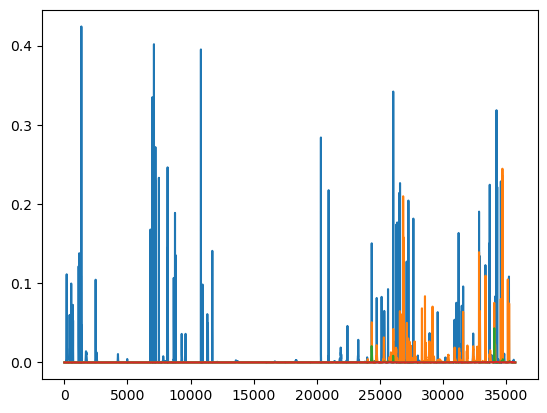

In [23]:


plt.plot(f11A_all_prob)

In [24]:
#plt.plot(f11A_probmatrixNPHI)

In [16]:
# this the clipped Gamma Ray log from the Comparitee vector

f11A_gr = cp_Comp.normalize_array(df_f11A['GR'][2600:].to_numpy(), 0, 0)
f11A_nphi =

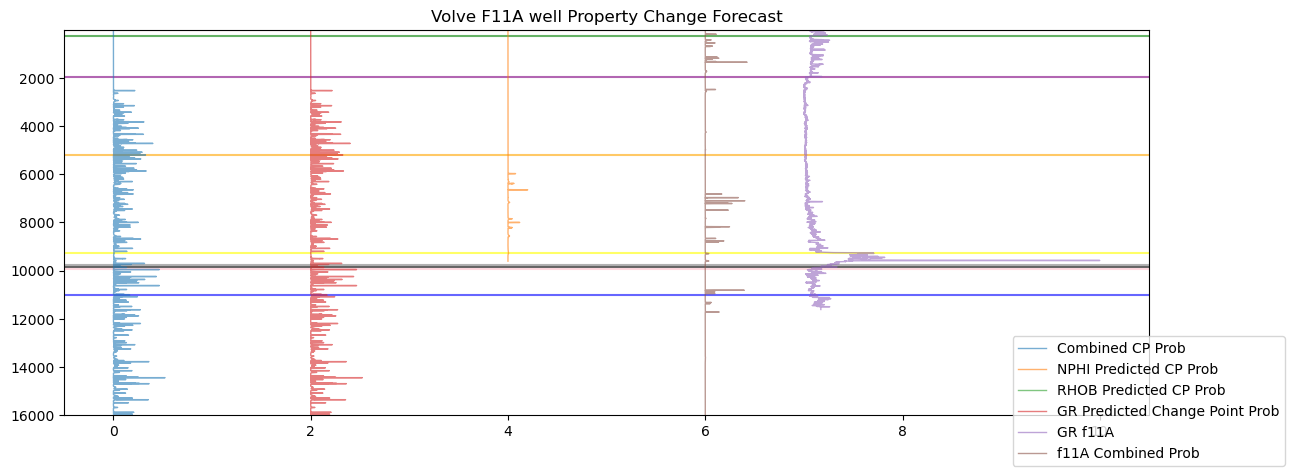

In [32]:
import matplotlib as mpl
#cmap = mpl.colormaps['']
fig, ax = plt.subplots(1, figsize=(14,5))
#plt.figure(figsize=(10,15))
ax.set_ylim(16000)
#ax.set_xlim(25)
f11A_top10 = f11A_tops*10-26000 #25400
k=0
for i in f11A_top10:
    ax.axhline(i, alpha=0.6, color=f11A_color[k])#, label=f11A_FM[k])
    #print(k)
    k=k+1
ax.plot(np.sum(f11A_probmatrix, axis=1), np.arange(len(f11A_probmatrix)), linewidth=1, alpha=.6, label='Combined CP Prob' )
ax.plot(np.sum(f11A_probmatrixNPHI, axis=1)+4, np.arange(len(f11A_probmatrixNPHI)), linewidth=1, alpha=.6, label = 'NPHI Predicted CP Prob' )
ax.plot(np.sum(f11A_probmatrixRHOB, axis=1)+6, np.arange(len(f11A_probmatrixRHOB)), linewidth=1, alpha=.6, label = 'RHOB Predicted CP Prob' )
#ax.plot(np.sum(f11A_probmatrixPEF, axis=1)+7.6, np.arange(len(f11A_probmatrixPEF)), linewidth=1, alpha=.6, label='PEF Predicted CP Prob')
ax.plot(np.sum(f11A_probmatrixGR, axis=1)+2, np.arange(len(f11A_probmatrixGR)), linewidth=1, alpha=.6, label = 'GR Predicted Change Point Prob' )
ax.plot(f11A_gr*3+ +7, np.arange(len(f11A_gr)) , linewidth=1, alpha=.6, label='GR f11A')
ax.plot(np.sum(f11A_all_prob, axis=1)+6, np.arange(len(f11A_all_prob)), linewidth=1, alpha=0.6, label='f11A Combined Prob')
maxx = len(df_f11A)

plt.title('Volve F11A well Property Change Forecast')
#f11A_top10
#cmap = plt.colormaps('turbo')


fig.legend(loc='lower right')

##### So, there are some issues with this result... mostly that they are ambiguous.

###### first and most obvious are that none of the formation tops (horizontal lines) have any obvious relation to the probaility mass of ony of the curves, frankly there is also a lot of noise. In the signal. 

In [1]:
import gempy as gp
gp.__version__
#geo_model = gp.create_model("synthetic_graben_model")


No module named 'osgeo'


'2.3.0'

In [1]:
import gempy as gp
import numpy as np

class well_from_graben_model(object):
    
    ''' This class has only one job and this is to toss out synthetic well logs for a gempy graben model (Lisa's)
    Density (RHO) and Porosity (PHI) are populated based on the lithology codes from the vertical borings
    
    Pro Tip!
    The compute_model function will bork without any additional values populated in the surface values, for reasons 
    that I am not sure of... some additonal features are built in the model, like sections and this was due to 
    previous attempts at creating well logs from 2D sections, which are still being worked with.
    
    Parameters:
        x : map section x position of sample (boring)
        y : map section y position of sample (boring)
        z_top : This is the top of the boring (nearer to the surface)
        z_bottom : This is the bottom of the boring (near the 'basement')
        res : Resolution of the log (number of equidistant samples)
        Rnoise : RHO (density) noise sigma (stdDev) for the convolution step (random normal, using the true value as mu)
        Pnoise : PHI (porosity) noise sigma
    '''
    
    def __init__(self, x, y, z_top, z_bottom, res, Rnoise, Pnoise):
        
        self.x = x
        self.y = y
        self.z_top = z_top
        self.z_bottom = z_bottom
        self.res = res
        self.Rnoise = Rnoise
        self.Pnoise = Pnoise
        #self.return_well = self.return_well(self.wellpath, self.welldata)
        #self.phi_rho = self.phi_rho
        #self.build_1d_well_path = self.build_1d_well_path
        
        data_path = 'https://raw.githubusercontent.com/cgre-aachen/gempy_data/master/'

        geo_model = gp.create_data('viz_3d',
                           [0, 2000, 0, 2000, 0, 1600],
                           [50, 50, 50],
                           path_o=data_path + "data/input_data/lisa_models/foliations" + str(
                               7) + ".csv",
                           path_i=data_path + "data/input_data/lisa_models/interfaces" + str(
                               7) + ".csv"
                                )

        gp.map_stack_to_surfaces(geo_model,
                                {"Fault_1": 'Fault_1', "Fault_2": 'Fault_2',
                                 "Strat_Series": ('Sandstone', 'Siltstone', 'Shale', 'Sandstone_2', 'Schist', 'Gneiss')}
                                )
        geo_model.add_surface_values([[0,0,.2, .3, .4, .2, .1, 0.03, .0], [0,0,2.1, 2, 1.8, 2.1, 2.4, 2.5, 2.9]], ['porosity', 'bulk_density'])
        geo_model.set_is_fault(['Fault_1', 'Fault_2'])
        section_dict = {'well1': ([100, 500], [100, 1100], [20, 20]), 'well2': ([10,2000],[2000,10],[100,100])
                }
        geo_model.set_section_grid(section_dict)
        #gp.plot.plot_section_traces(geo_model)
        geo_model.get_active_grids()
        #gp.set_interpolator(geo_model, theano_optimizer='fast_compile')
        #geo_model.get_active_grids()
        self.well_path = self.build_1d_well_path(x, y, z_top, z_bottom, res)
        print(self.well_path[:4])
        geo_model.get_active_grids()
        
        gp.set_interpolator(geo_model, theano_optimizer='fast_compile')
        
        sol = gp.compute_model(geo_model, at=self.well_path)
        self.well_data = self.phi_rho(sol, self.Rnoise, self.Pnoise)
        print(self.well_data[:1])
        #self.return_well(self.well_path, self.well_data)
        
        #return self.well_path, self.well_data
    #if __name__ == '__main__':
    
    def build_1d_well_path(self, x, y, z_top, z_bottom, res): #z_bottom and z_top are relative to a lower model boundary (basement) zero point, which puts the surface closer to zero 
        x = np.ones(res)*x
        y = np.ones(res)*y
        z = np.linspace(z_bottom , z_top, res)
        #well_path1 = np.empty(3)

        for i in range(res):
            if i == 0:
                well_path= np.array((x[0],y[0],z[0]))
            else:
                well_path = np.vstack((well_path, np.array((x[i],y[i],z[i]))), dtype=object)
        return well_path

    def phi_rho(self, sol, Rnoise, Pnoise):
        phi = []
        rho = []
        phiRho = np.vstack(([0,0,0,.2, .3, .4, .2, .1, 0.03, .0], [0,0,0,2.1, 2, 1.8, 2.1, 2.4, 2.5, 2.9]))
        #phiRho[1,4]
        for i in sol.custom[0][0]: 
            i = int(i)
            phi.append(phiRho[0,i])
            rho.append(phiRho[1,i])
        phiNoise = np.random.normal(phi, Pnoise)
        rhoNoise = np.random.normal(rho, Rnoise)
        return phi, phiNoise, rho, rhoNoise
    
    def return_well(self):
        return self.well_path, self.well_data
    
        
        
        
    

No module named 'osgeo'


In [34]:
#import synthetic_graben_model as grab
# data_path = 'https://raw.githubusercontent.com/cgre-aachen/gempy_data/master/'

# geo_model = gp.create_data('viz_3d',
#                            [0, 2000, 0, 2000, 0, 1600],
#                            [50, 50, 50],
#                            path_o=data_path + "data/input_data/lisa_models/foliations" + str(
#                                7) + ".csv",
#                            path_i=data_path + "data/input_data/lisa_models/interfaces" + str(
#                                7) + ".csv"
#                            )

wellpath1, welldata1 = well_from_graben_model(10, 10, 1600, 0, 1600, .08, .04).return_well() #( x, y, z_top, z_bottom, res, Rnoise, Pnoise)
wellpath2, welldata2 = well_from_graben_model(1900, 1900, 1600, 0, 1600, .08, .04).return_well()
wellpath3, welldata3 = well_from_graben_model(1000, 1000, 1600, 0, 1600, .08, .04).return_well()
wellpath4, welldata4 = well_from_graben_model(600, 1700, 1600, 0, 1600, .08, .04).return_well()

randx = np.random.randint(0,2000)
randy = np.random.randint(0,2000)
randz = np.random.randint(0,1600)

randI = np.random.randint
randIz1 = randI(0,1600)
randIz2 = randI(0,1600)

wellpathRand1, welldataRand1 = well_from_graben_model(randI(0,2000), randI(0,2000), randIz1, 0, randIz1, .08, .03).return_well()
wellpathRand2, welldataRand2 = well_from_graben_model(randI(0,2000), randI(0,2000), randIz2, 0, randIz2 , .08, .03).return_well()

IndexError: invalid index to scalar variable.

In [1]:
import pandas as pd
pd.__version__


'2.0.3'